# Getting Started with Dataflux Dataset for PyTorch with Google Cloud Storage

In this demo, we will go through sample usages with the Dataflux Dataset for PyTorch, including data loading primitives and checkpointing.


## Installation

First, we install the Dataflux Dataset for PyTorch.

In [1]:
! pip install gcs-torch-dataflux

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.7 MB/s eta 0:00:00


Then we install all the packages that are needed for this walkthrough.

In [2]:
!pip install torch torchvision Pillow

## Preparation

After installing all required packages, we must perform some additional preparation.

First, we set up the [authentication](https://github.com/GoogleCloudPlatform/dataflux-pytorch?tab=readme-ov-file#configuration) needed to run the notebook.

Modify the `PROJECT_ID` field to your own project ID.

In [3]:
from google.colab import auth
PROJECT_ID = "YOUR_PROJECT_ID"
auth.authenticate_user(project_id=PROJECT_ID)

**Next**, we create our own bucket in our project and copy the demo dataset from the [public bucket](https://console.cloud.google.com/storage/browser/dataflux-demo-public/simple-demo-dataset) to our own bucket. This is necessary because we only have read permission to the public bucket but we will need write permission to perform some operations later in the tutorial.

The [public bucket](https://console.cloud.google.com/storage/browser/dataflux-demo-public/simple-demo-dataset) contains 100 images from the [poloclub/diffusiondb dataset](https://huggingface.co/datasets/poloclub/diffusiondb).

In [4]:
BUCKET_NAME = "YOUR_OWN_BUCKET"

In [ ]:
# Create a new bucket in our project with the standard storage class.
from google.cloud import storage

storage_client = storage.Client()
bucket = storage_client.bucket(BUCKET_NAME)
bucket.storage_class = "STANDARD"
new_bucket = storage_client.create_bucket(bucket, location="us")

print("New bucket created.")

New bucket created.


In [ ]:
# Copy all the files from the public dataflux-demo-public/simple-demo-dataset
# directory into our own bucket.

from google.cloud import storage

storage_client = storage.Client()
source_bucket = storage_client.bucket("dataflux-demo-public")
all_files = [filename.name for filename in
             source_bucket.list_blobs(prefix="simple-demo-dataset")]

for i in range(len(all_files)):
  source_blob = source_bucket.blob(all_files[i])
  source_bucket.copy_blob(source_blob, new_bucket, all_files[i])

print("All files copied from the public bucket to our own bucket.")

All files copied from the public bucket to our own bucket


## Data Loading Primitives



### Dataflux Map-style Dataset
In this section, we will illustrate how the `DataFluxMapStyleDataset` supports the PyTorch data loading primitives as a [map-style dataset](https://pytorch.org/docs/stable/data.html#map-style-datasets).

First, we construct a `DataFluxMapStyleDataset` with the project name, the bucket name and the prefix.

In [5]:
from dataflux_pytorch import dataflux_mapstyle_dataset

PREFIX = "simple-demo-dataset"

dataset = dataflux_mapstyle_dataset.DataFluxMapStyleDataset(
    project_name=PROJECT_ID,
    bucket_name=BUCKET_NAME,
    config=dataflux_mapstyle_dataset.Config(prefix=PREFIX),
)

print(len(dataset.objects))

100


During construction, the `DataFluxMapStyleDataset` lists the objects in the bucket with the specified prefix and stores the object name and size (in bytes) within the `objects` variable.

In [6]:
dataset.objects[0]

('simple-demo-dataset/0002f5ec-7502-4211-b64d-dfdcbc79a3c4.png', 1027524)

Each element of the `dataset` now represents the content of the object in bytes. We will convert it to a binary I/O stream before passing it to `Image.open()` which requires the input to be a file-like object.

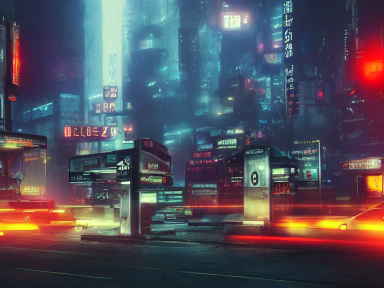

In [ ]:
import io
from PIL import Image

Image.open(io.BytesIO(dataset[0])).reduce(2)

We can iterate over the `dataset` since PyTorch map-style datasets are iterators.

'simple-demo-dataset/00013df5-e53a-46d5-86db-f1e9d14f49a1.png'

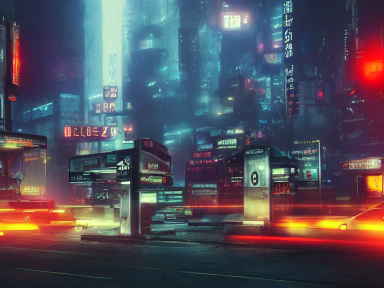

'simple-demo-dataset/0002dcd1-73b9-4b4e-882d-ff3a82b279dc.png'

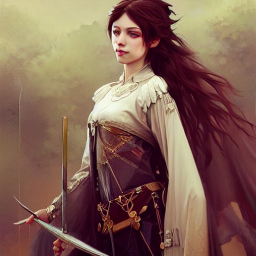

'simple-demo-dataset/0001fb87-8366-47a8-9107-d4e4c90680c0.png'

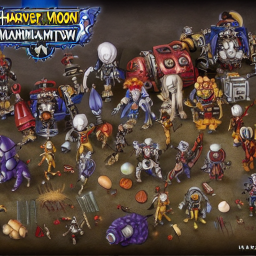

'simple-demo-dataset/0000e874-3591-4e9b-a703-6186ea90eea4.png'

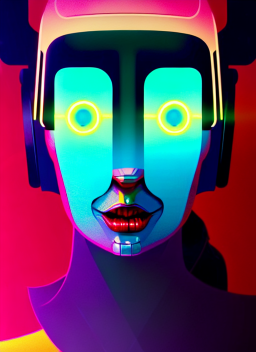

'simple-demo-dataset/00029598-bc99-4e44-acca-eb1fd5126c97.png'

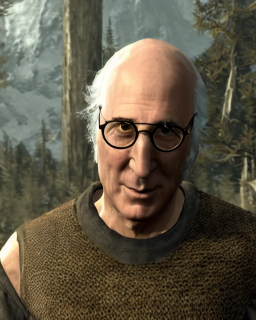

In [ ]:
# We will only display 5 of the 100 samples in the dataset.
count = 0
for object in dataset:
  display(dataset.objects[count][0])
  display(Image.open(io.BytesIO(object)).reduce(2))
  count += 1
  if (count == 5):
    break

### Dataflux Iterable-style Dataset

In this section, we will illustrate how the `DatafluxIterableDataset` supports the PyTorch data loading primitives as an [iterable dataset](https://pytorch.org/docs/stable/data.html#iterable-style-datasets).

In [7]:
from dataflux_pytorch import dataflux_iterable_dataset

PREFIX = "simple-demo-dataset"

iterable_dataset = dataflux_iterable_dataset.DataFluxIterableDataset(
    project_name=PROJECT_ID,
    bucket_name=BUCKET_NAME,
    config=dataflux_mapstyle_dataset.Config(prefix=PREFIX),
)

The `iterable_dataset` now represents an iterable over data samples.

'simple-demo-dataset/0002f5ec-7502-4211-b64d-dfdcbc79a3c4.png'

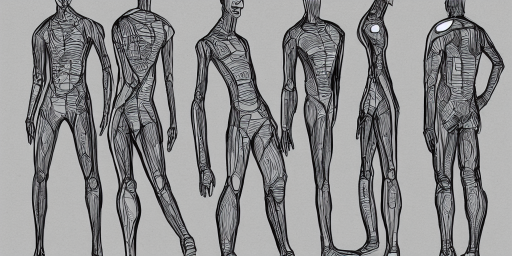

'simple-demo-dataset/000037d4-1b05-4092-8613-afa025312014.png'

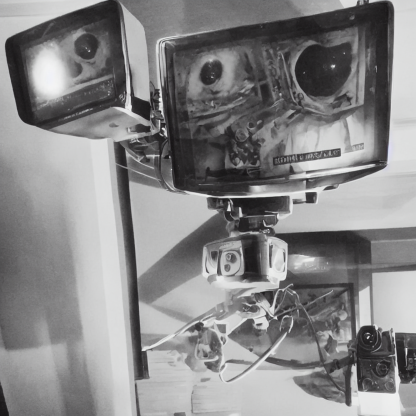

'simple-demo-dataset/00009c63-5115-4f81-b7ff-83a61e98b119.png'

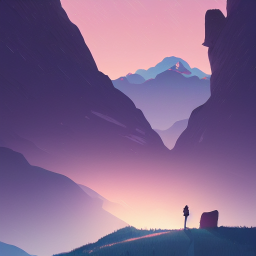

'simple-demo-dataset/00020510-f831-4b8b-8bd7-562ff05ee213.png'

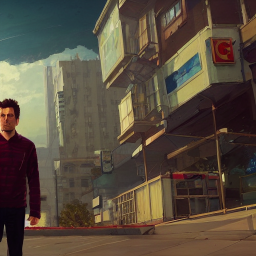

'simple-demo-dataset/000127d0-d378-410f-b484-057bab9c890d.png'

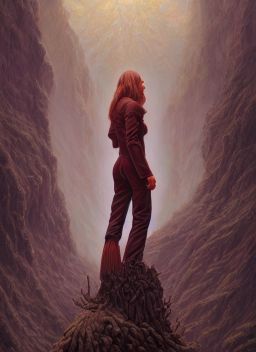

In [10]:
import io
from PIL import Image

# We will only display 5 of the 100 samples in the iterable_dataset.
count = 0
for object in iterable_dataset:
  display(iterable_dataset.objects[count][0])
  display(Image.open(io.BytesIO(object)).reduce(2))
  count += 1
  if (count == 5):
    break

## Working with PyTorch DataLoaders

### Dataflux Map-style Dataset
Most real-world training loops work with [PyTorch DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) to make use of batching, shuffling and Python's `multiprocessing` to speed up data loading. Because `DataFluxMapStyleDataset` implements the map-style dataset, it is fully compatiable with the PyTorch `DataLoader`.

Additionally, because real-world training loops mostly work with Numpy arrays or PyTorch tensors, `DataFluxMapStyleDataset` provides a `data_format_fn` that converts the downloaded content of the object from raw bytes into those formats, or any format as you wish. This function is applied to every object fetched from the bucket.

In [ ]:
import torch
import torchvision

def load_image(content_bytes):
  img = Image.open(io.BytesIO(content_bytes)).resize((512, 512))
  return torchvision.transforms.functional.pil_to_tensor(img)

dataset = dataflux_mapstyle_dataset.DataFluxMapStyleDataset(
    project_name=PROJECT_ID,
    bucket_name=BUCKET_NAME,
    config=dataflux_mapstyle_dataset.Config(
        prefix=PREFIX,
        sort_listing_results=True,
    ),
    data_format_fn=load_image,
)

loader = torch.utils.data.DataLoader(
    dataset,
    num_workers=2,
    batch_size=20,
    shuffle=True,
)
for batch in loader:
  print(batch.shape)

torch.Size([20, 3, 512, 512])
torch.Size([20, 3, 512, 512])
torch.Size([20, 3, 512, 512])
torch.Size([20, 3, 512, 512])
torch.Size([20, 3, 512, 512])


### Dataflux Iterable-style Dataset

Similarly for `DatafluxIterableDataset`, because it fully subclasses the iterable-style dataset, it is fully compatiable with the PyTorch `DataLoader`.

As the documentation of `IterableDataset` [points out](https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset),

> *When num_workers > 0, each worker process will have a different copy of the dataset object, so it is often desired to configure each copy independently to avoid having duplicate data returned from the workers*

The `DatafluxIterableDataset` follows the best practice to partition the dataset into separate copies for different workers using the `get_worker_info()` function.

In [12]:
import torch
import torchvision

def load_image(content_bytes):
  img = Image.open(io.BytesIO(content_bytes)).resize((512, 512))
  return torchvision.transforms.functional.pil_to_tensor(img)

dataset = dataflux_iterable_dataset.DataFluxIterableDataset(
    project_name=PROJECT_ID,
    bucket_name=BUCKET_NAME,
    config=dataflux_mapstyle_dataset.Config(
        prefix=PREFIX,
        sort_listing_results=True,
    ),
    data_format_fn=load_image,
)

loader = torch.utils.data.DataLoader(
    dataset,
    num_workers=2,
    batch_size=20,
)
for batch in loader:
  print(batch.shape)

torch.Size([20, 3, 512, 512])
torch.Size([20, 3, 512, 512])
torch.Size([20, 3, 512, 512])
torch.Size([20, 3, 512, 512])
torch.Size([10, 3, 512, 512])
torch.Size([10, 3, 512, 512])


## Performance Optimizations

### Data Listing

When working with cloud storage solutions such as GCS, data listing performance is critical to enabling support for map-style datasets' random access patterns.

When a `DataFluxMapStyleDataset` or `DataFluxIterableDataset` is constructed with the dataset information such as `project_name`, `bucket_name` and an optional `prefix`, it will employ a fast listing algorithm to quickly fetch the list of data samples in the dataset. You can read more about the algorithm in the underlying `dataflux-client-python` README [here](https://github.com/GoogleCloudPlatform/dataflux-client-python?tab=readme-ov-file#fast-list).

To demonstrate the performance benefit with fast listing, we will use the [public bucket](https://console.cloud.google.com/storage/browser/dataflux-demo-public/diffusiondb-large) which contains around 2 million objects from the [poloclub/diffusiondb dataset](https://huggingface.co/datasets/poloclub/diffusiondb).

In [ ]:
from time import time
from dataflux_pytorch import dataflux_mapstyle_dataset

t0 = time()
dataset = dataflux_mapstyle_dataset.DataFluxMapStyleDataset(
    project_name=PROJECT_ID,
    bucket_name="dataflux-demo-public",
    config=dataflux_mapstyle_dataset.Config(
        prefix="diffusiondb-large/",
        num_processes=1,
    ),
)
t1 = time()
print(f"With sequential listing, it takes {t1-t0} seconds to list the dataset "
      f"of {len(dataset.objects)} objects.")

With sequential listing, it takes 146.16410398483276 seconds to list the dataset of 1999002 objects.


In [ ]:
t0 = time()
dataset = dataflux_mapstyle_dataset.DataFluxMapStyleDataset(
    project_name=PROJECT_ID,
    bucket_name="dataflux-demo-public",
    config=dataflux_mapstyle_dataset.Config(
        prefix="diffusiondb-large/",
        num_processes=5,
    ),
)
t1 = time()
print(f"With fast listing, it takes {t1-t0} seconds to list the dataset of "
      f"{len(dataset.objects)} objects.")

With fast listing, it takes 69.39731621742249 seconds to list the dataset of 1999002 objects.


In [ ]:
import os

os.cpu_count()

2

Using the two available CPUs in the Colab runtime, fast listing can improve performance by 2x (from 146 to 69 seconds).

### Data Loading
`DataFluxMapStyleDataset` subclasses `torch.utils.data.Dataset` and implements the `__getitems__()` method ([ref](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)) to speed up batched samples loading.

During training, `DataFluxMapStyleDataset`'s `__getitems__()` method receives a list (length=`batch_size`) of indices from `DataLoader` and performs "batch downloading" from the GCS bucket. In the case of small data samples (100 - 500 KB), `DataFluxMapStyleDataset` utilizes the [GCS Compose API](https://cloud.google.com/storage/docs/json_api/v1/objects/compose) to concatenate a set of smaller objects into a new combined object in the same bucket. Then it will download the larger object and split it into the smaller ones before removing the composed object from the bucket. See more about this feature in the [README](https://github.com/GoogleCloudPlatform/dataflux-pytorch?tab=readme-ov-file#composite-objects) and the underlying ["dataflux-client-python"](https://github.com/GoogleCloudPlatform/dataflux-client-python) library.

To demonstrate the performance benefits of composed download, we use the same demo bucket we created.

In [ ]:
from time import time
from PIL import Image
import torch
import torchvision
import io

from dataflux_pytorch import dataflux_mapstyle_dataset

def load_image(content_bytes):
  img = Image.open(io.BytesIO(content_bytes)).resize((512, 512))
  return torchvision.transforms.functional.pil_to_tensor(img)

dataset = dataflux_mapstyle_dataset.DataFluxMapStyleDataset(
    project_name=PROJECT_ID,
    bucket_name=BUCKET_NAME,
    config=dataflux_mapstyle_dataset.Config(
        prefix=PREFIX,
        sort_listing_results=True,
    ),
    data_format_fn=load_image,
)

loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=20,
)

t1 = time()
for batch in loader:
  pass
t2 = time()
print(f"With composed downloading behavior turned on, loading the entire dataset"
      f" took {t2 - t1} seconds")

With composed downloading behavior turned on, loading the entire dataset took 7.327934503555298 seconds


As the [README](https://github.com/GoogleCloudPlatform/dataflux-pytorch?tab=readme-ov-file#composite-objects) indicates, we can turn off this behavior by specifying `max_composite_object_size=0`.

In [ ]:
dataset = dataflux_mapstyle_dataset.DataFluxMapStyleDataset(
    project_name=PROJECT_ID,
    bucket_name=BUCKET_NAME,
    config=dataflux_mapstyle_dataset.Config(
        prefix=PREFIX,
        sort_listing_results=True,
        max_composite_object_size=0,
    ),
    data_format_fn=load_image,
)

loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=20,
)

t1 = time()
for batch in loader:
  pass
t2 = time()
print(f"With composed downloading behavior turned off, loading the entire dataset"
      f" took {t2 - t1} seconds")

With composed downloading behavior turned off, loading the entire dataset took 12.149227380752563 seconds


You can see that it roughly takes 50% longer to load the entire dataset when the composed download behavior is turned off. This difference becomes more prominent when the dataset is larger and the `batch_size` is larger. See more about the [Performance](https://github.com/GoogleCloudPlatform/dataflux-pytorch?tab=readme-ov-file#performance) in the README.

## Checkpointing

Checkpointing is integral to extensive machine learning tasks as it avoids the need to restart from the beginning in the case of failures, thereby conserving precious resources and time.

The Dataflux Dataset for PyTorch provides a convenient interface for saving and loading model checkpoints directly to and from a GCS bucket, therefore avoiding the need to manage the local storage.

To use the checkpointing interface, first construct a `DatafluxCheckpoint` object:

In [ ]:
from dataflux_pytorch import dataflux_checkpoint

ckpt = dataflux_checkpoint.DatafluxCheckpoint(
  project_name=PROJECT_ID, bucket_name=BUCKET_NAME
)
CKPT_PATH = "checkpoints/epoch0.ckpt"

To save a model checkpoint, use the `writer` method to create a binary stream to pass directly to `torch.save()`.

In [ ]:
model = torchvision.models.resnet50()

with ckpt.writer(CKPT_PATH) as writer:
  torch.save(model.state_dict(), writer)

To load a model checkpoint use the `reader` method to create a different binary stream to pass directly into `torch.load()`.

In [ ]:
with ckpt.reader(CKPT_PATH) as reader:
  read_state_dict = torch.load(reader)

model.load_state_dict(read_state_dict)

<All keys matched successfully>